In [2]:
import pickle
import os
import numpy as np
from scipy.spatial import distance
import math
from math import radians, cos, sin, asin, sqrt
import random
import torch
import torch.utils.data as torchdata
from torch.nn import init
import time
from torch import nn
from gensim.models import Word2Vec
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
#計算經緯度距離的公式
def dis(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

def Gaussian(sigma,distance):
    return np.exp((-(distance**2))/(2*sigma**2))

In [4]:
#讀取過濾後的資料，dname切換東京和紐約資料
dname='nyc'
#dname='tky'
data=pd.read_csv('../data/'+dname+'_filter_data.csv')
print(len(data))
poiNum=len(data.groupby('venueid'))
catNum=len(data.groupby('categid'))
userNum=len(data.groupby('userid'))
print(poiNum)
print(catNum)
print(userNum)
print(data.columns)


147729
5130
208
1083
Index(['userid', 'venueid', 'catid', 'catname', 'latitute', 'longitude',
       'timezone', 'time', 'categid', 'timestamp', 'hour', 'day', 'week',
       'hour_48'],
      dtype='object')


In [5]:
#建POI辭典
poiDic={}
for cid,i in data.iterrows():
    if i['venueid'] not in poiDic.keys():
        poiDic[i['venueid']]=[i['longitude'],i['latitute'],i['catname']]
print(len(poiDic))

5130


In [27]:
#分析使用者移動距離分布
group=data.groupby('userid')
dlist=[]
for gid,j in group:
    j=j.sort_values(by='timestamp')
    pastlong=0
    pastlat=0
    now=0
    past=0
    for cid,i in j.iterrows():
        past=now
        now=i['timestamp']
        time_int=now-past
        if past!=0 and time_int<24*60*60:
            dist=dis(i['longitude'],i['latitute'],pastlong,pastlat)
            dlist.append(dist)
        pastlong=i['longitude']
        pastlat=i['latitute']

l=len(dlist)
dlist=sorted(dlist)
print(l)
print('avg:',sum(dlist)/len(dlist))
print("1/4:",dlist[int(l/4)])
print("1/2:",dlist[int(l/2)])
print("7/10:",dlist[int(l*7/10)])
print("3/4:",dlist[int(l*3/4)])

100620
avg: 3.800053551416633
1/4: 0.17882452231813556
1/2: 1.156626982775126
7/10: 3.969041842343574
3/4: 5.140021235858542


In [60]:
#位置距離圖
connect=0
graph=np.zeros((poiNum,poiNum))
len_limit=2         #距離門檻
sig=1       #sig 越大數字越大
maxdis=0
mindis=10000
for i in poiDic.keys():
    for j in poiDic.keys():
        distance=dis(poiDic[i][0],poiDic[i][1],poiDic[j][0],poiDic[j][1])
        if distance>maxdis:
            maxdis=distance
        if distance<mindis and distance!=0:
            mindis=distance
        if distance<=len_limit and distance>0:
            connect+=1
            graph[i][j]=Gaussian(sig,distance)
        

print(len(graph))
print(maxdis)
print(mindis)
np.save('../list/'+dname+'_dis_graph',graph)

440.18557504873297
5130
49.62806204029162
0.0003538064661719978


13.94999706196129


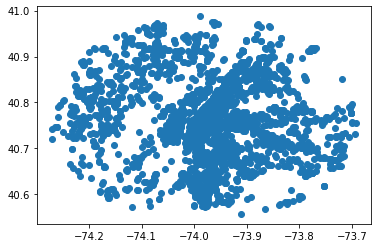

<Figure size 2880x1440 with 0 Axes>

In [12]:
x=[]
y=[]
for i in poiDic.values():
    x.append(i[0])
    y.append(i[1])
plt.scatter(x, y)
print(dis(-74.0,40.7,-73.9,40.8))
plt.figure(figsize=(40, 20))
plt.show()

In [5]:
#頻率圖
freqGraph=np.zeros((poiNum,poiNum))
group=data.groupby('userid')
for gid,j in group:
    j=j.sort_values(by='timestamp')
    outId=-1
    inId=-1
    past=0
    now=0
    for cid,i in j.iterrows():
        outId=inId
        past=now
        inId=i['venueid']
        now=i['timestamp']
        time_int=now-past
        if outId!=-1 and time_int<24*60*60:
            freqGraph[outId][inId]+=1

print(freqGraph.shape)
np.save('../list/'+dname+'_freq_graph',freqGraph)

(7870, 7870)
